In [44]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
import math
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Activation, Flatten
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBRegressor , XGBClassifier
import lightgbm as lgb 
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.float_format', '{:.2f}'.format)

In [7]:
stocks = {}
stocks['CMG'] = pd.read_csv(r'C:\Users\user\Documents\python\Data_Explorers_2025\Round2\Data - 12ndMar\4.2.3 (TARGET) (live & his) CMG_detail_transactions_processed.csv')
stocks['FPT'] = pd.read_csv(r'C:\Users\user\Documents\python\Data_Explorers_2025\Round2\Data - 12ndMar\4.2.3 (TARGET) (live & his) FPT_detail_transactions_processed.csv')

In [8]:
for key, value in stocks.items():
    print('Stock of:', key)
    print(value.info())
    print("="*30)

Stock of: CMG
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   StockID         250 non-null    object 
 1   Date            250 non-null    object 
 2   Total Volume    250 non-null    object 
 3   Total Value     250 non-null    object 
 4   Market Cap      250 non-null    object 
 5   Closing Price   250 non-null    object 
 6   Price Change    250 non-null    object 
 7   Price Change %  250 non-null    float64
 8   Matched Volume  250 non-null    object 
 9   Matched Value   250 non-null    object 
dtypes: float64(1), object(9)
memory usage: 19.7+ KB
None
Stock of: FPT
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   StockID         240 non-null    object 
 1   Date            240 non-

In [9]:
lst = ['Total Volume', 'Total Value', 'Market Cap',
       'Closing Price', 'Price Change', 'Matched Volume', 'Matched Value']

for key, value in stocks.items():
    value.drop(columns='StockID', inplace=True)
    value['Date'] = pd.to_datetime(value['Date'], format='%d/%m/%Y')
    for col in lst:
        value[col] = value[col].replace(',', '', regex=True).astype(float)
    value = value.iloc[::-1]
    value.set_index('Date', inplace=True)
    stocks[key] = value

## EDA

In [5]:
for key, value in stocks.items():
    print('Stock of:', key)
    print(value.describe().T)
    print("="*30)

Stock of: CMG
                count        mean        std        min        25%        50%  \
Total Volume   250.00  1438353.61 1052372.37  111800.00  672675.00 1142400.00   
Total Value    250.00    79618.08   64748.25    4416.00   33594.00   58143.50   
Market Cap     250.00 10119008.16 1323429.16 7468061.00 9400881.75 9919710.00   
Closing Price  250.00    52473.00    7455.03   39300.00   46112.50   51900.00   
Price Change   250.00       33.60    1423.68   -4200.00    -700.00       0.00   
Price Change % 250.00        0.11       2.65      -7.00      -1.37       0.00   
Matched Volume 250.00  1349480.40 1046390.23  111800.00  603875.00 1029400.00   
Matched Value  250.00    74891.13   64201.49    4416.00   29819.00   50823.50   

                       75%         max  
Total Volume    1952575.00  7646900.00  
Total Value      112292.25   432156.00  
Market Cap     10772328.50 13445014.00  
Closing Price     56575.00    70600.00  
Price Change        800.00     4200.00  
Price Chan

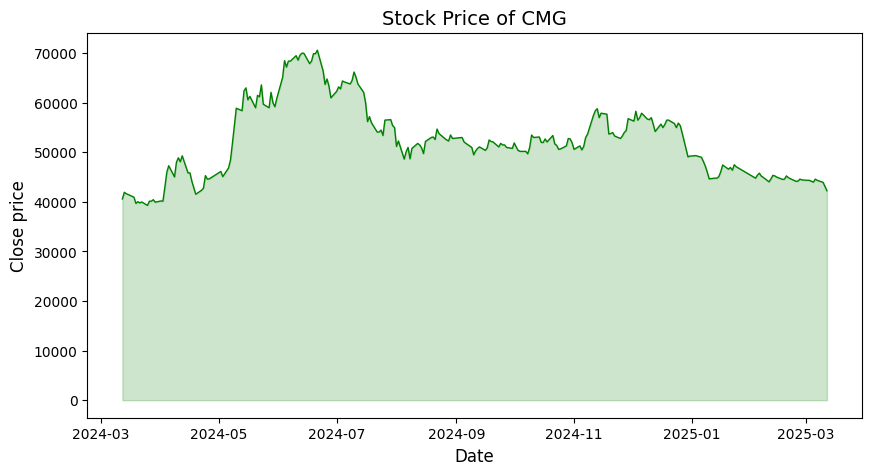

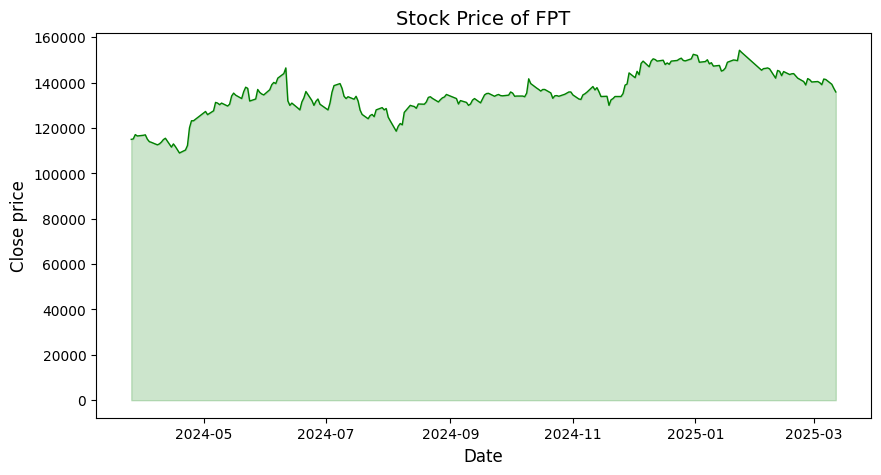

In [6]:
for company, data in stocks.items():
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(data['Closing Price'], color='green', linewidth=1)

    ax.fill_between(data.index, data['Closing Price'], alpha=0.2, color='green')

    ax.set_title(f"Stock Price of {company}", fontsize=14)
    ax.set_xlabel("Date", fontsize=12)
    ax.set_ylabel("Close price", fontsize=12)

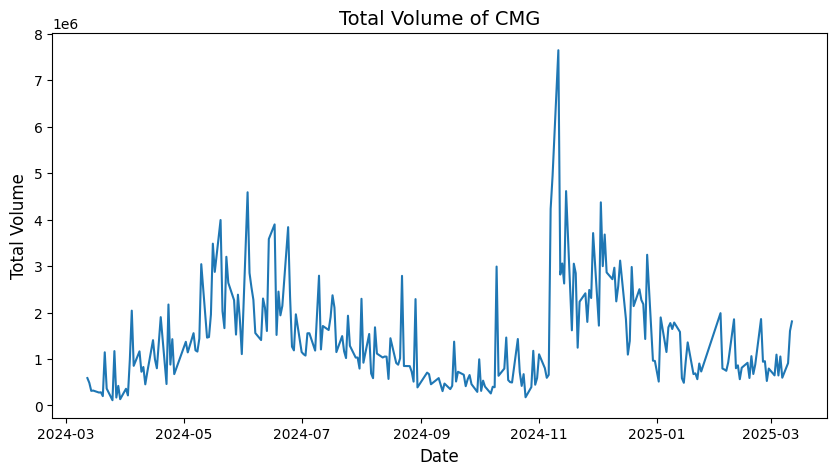

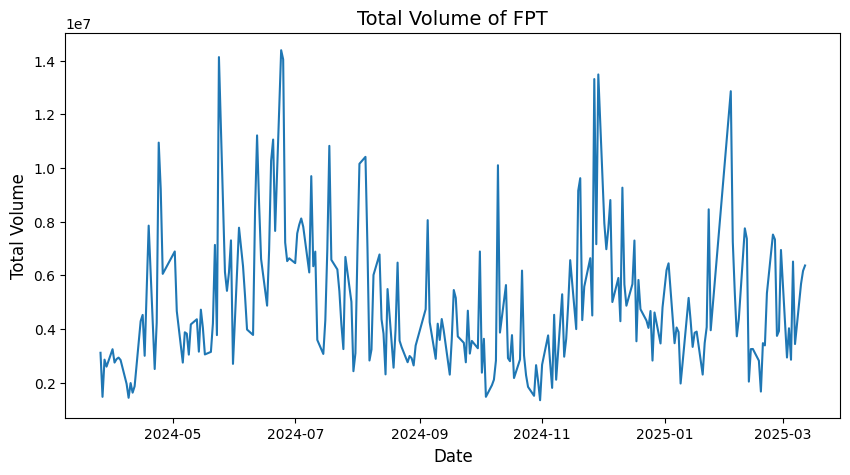

In [7]:
for company, data in stocks.items():
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(data['Total Volume'])

    ax.set_title(f"Total Volume of {company}", fontsize=14)
    ax.set_xlabel("Date", fontsize=12)
    ax.set_ylabel("Total Volume", fontsize=12)

Cổ phiếu CMG


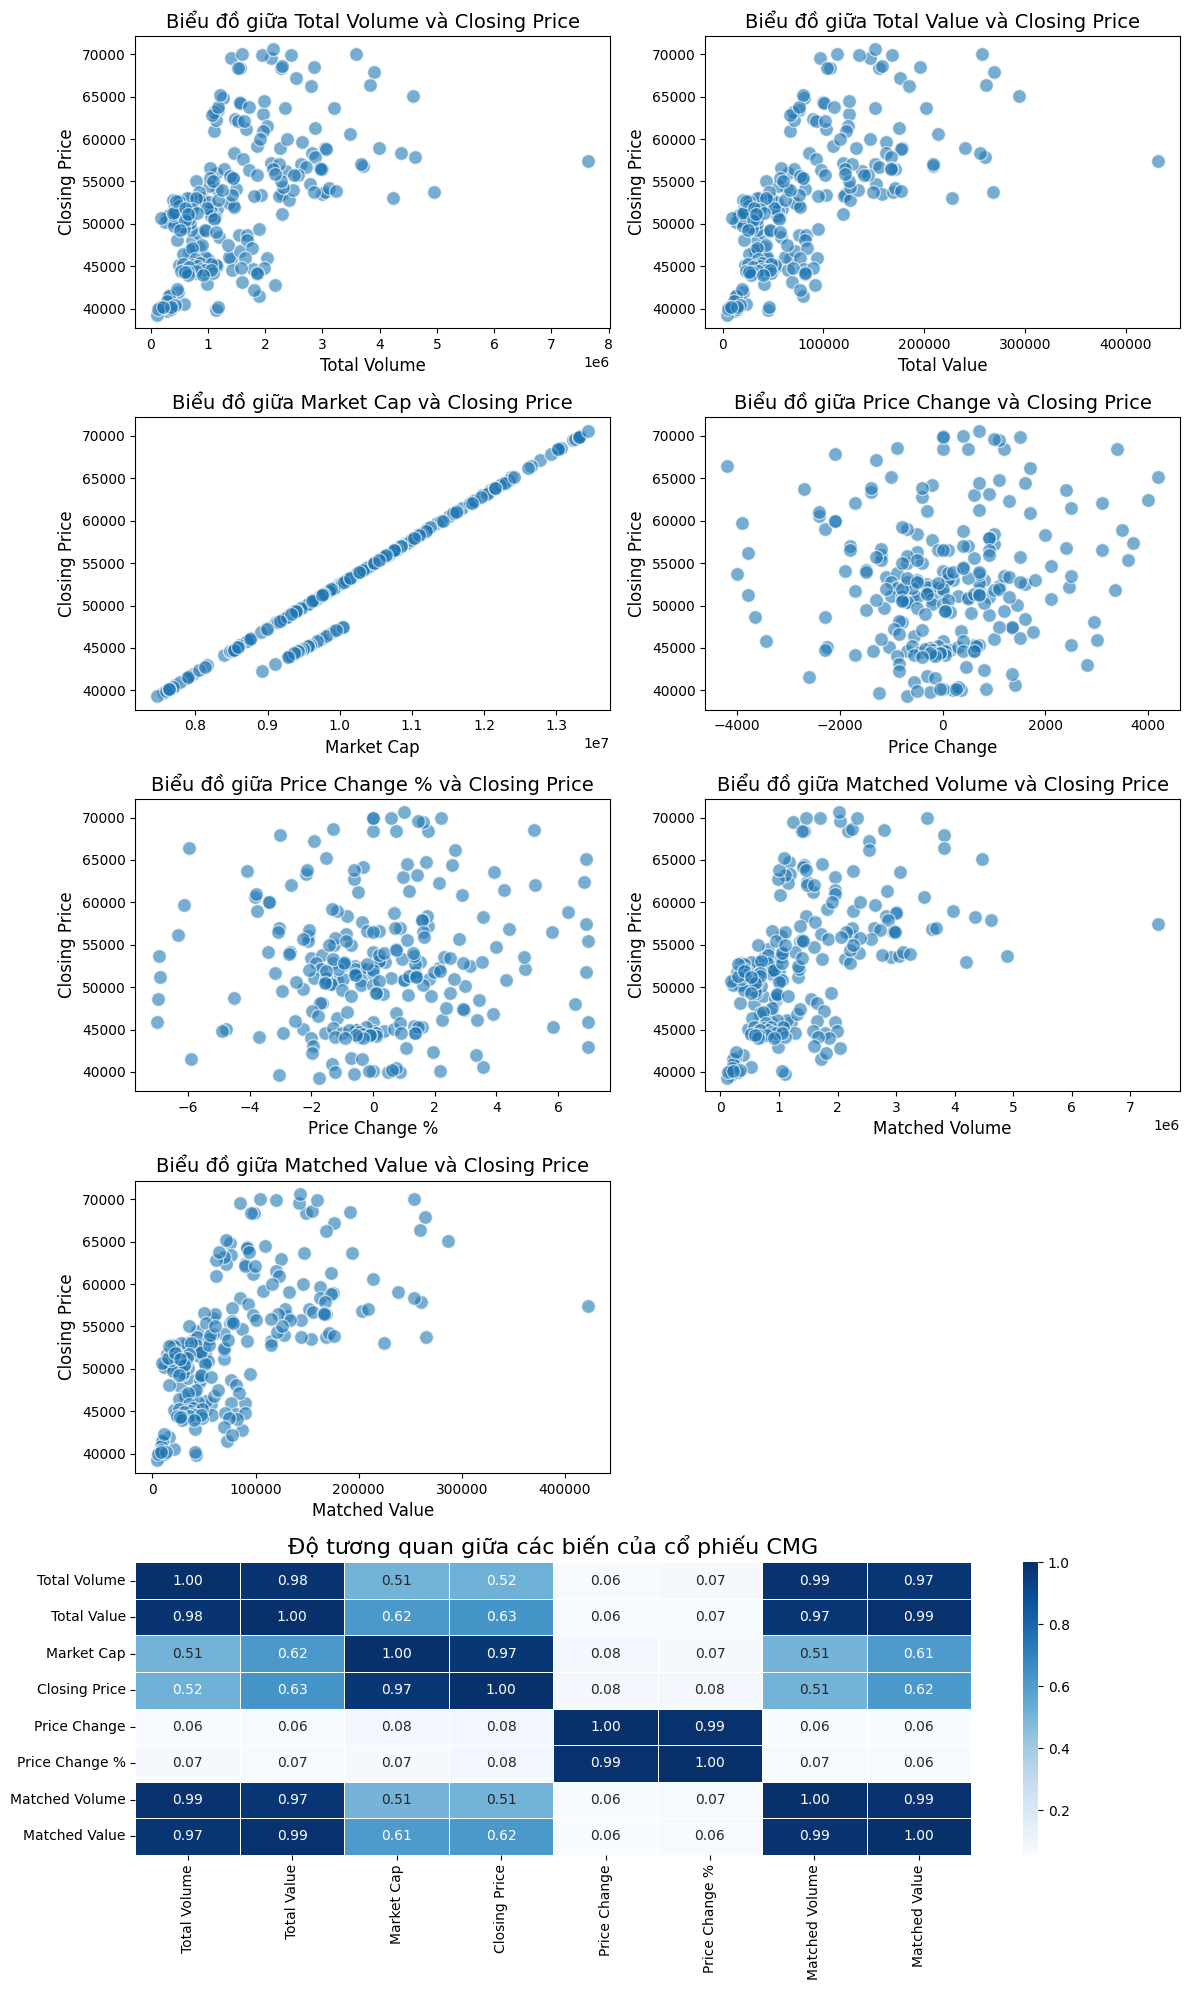

Cổ phiếu FPT


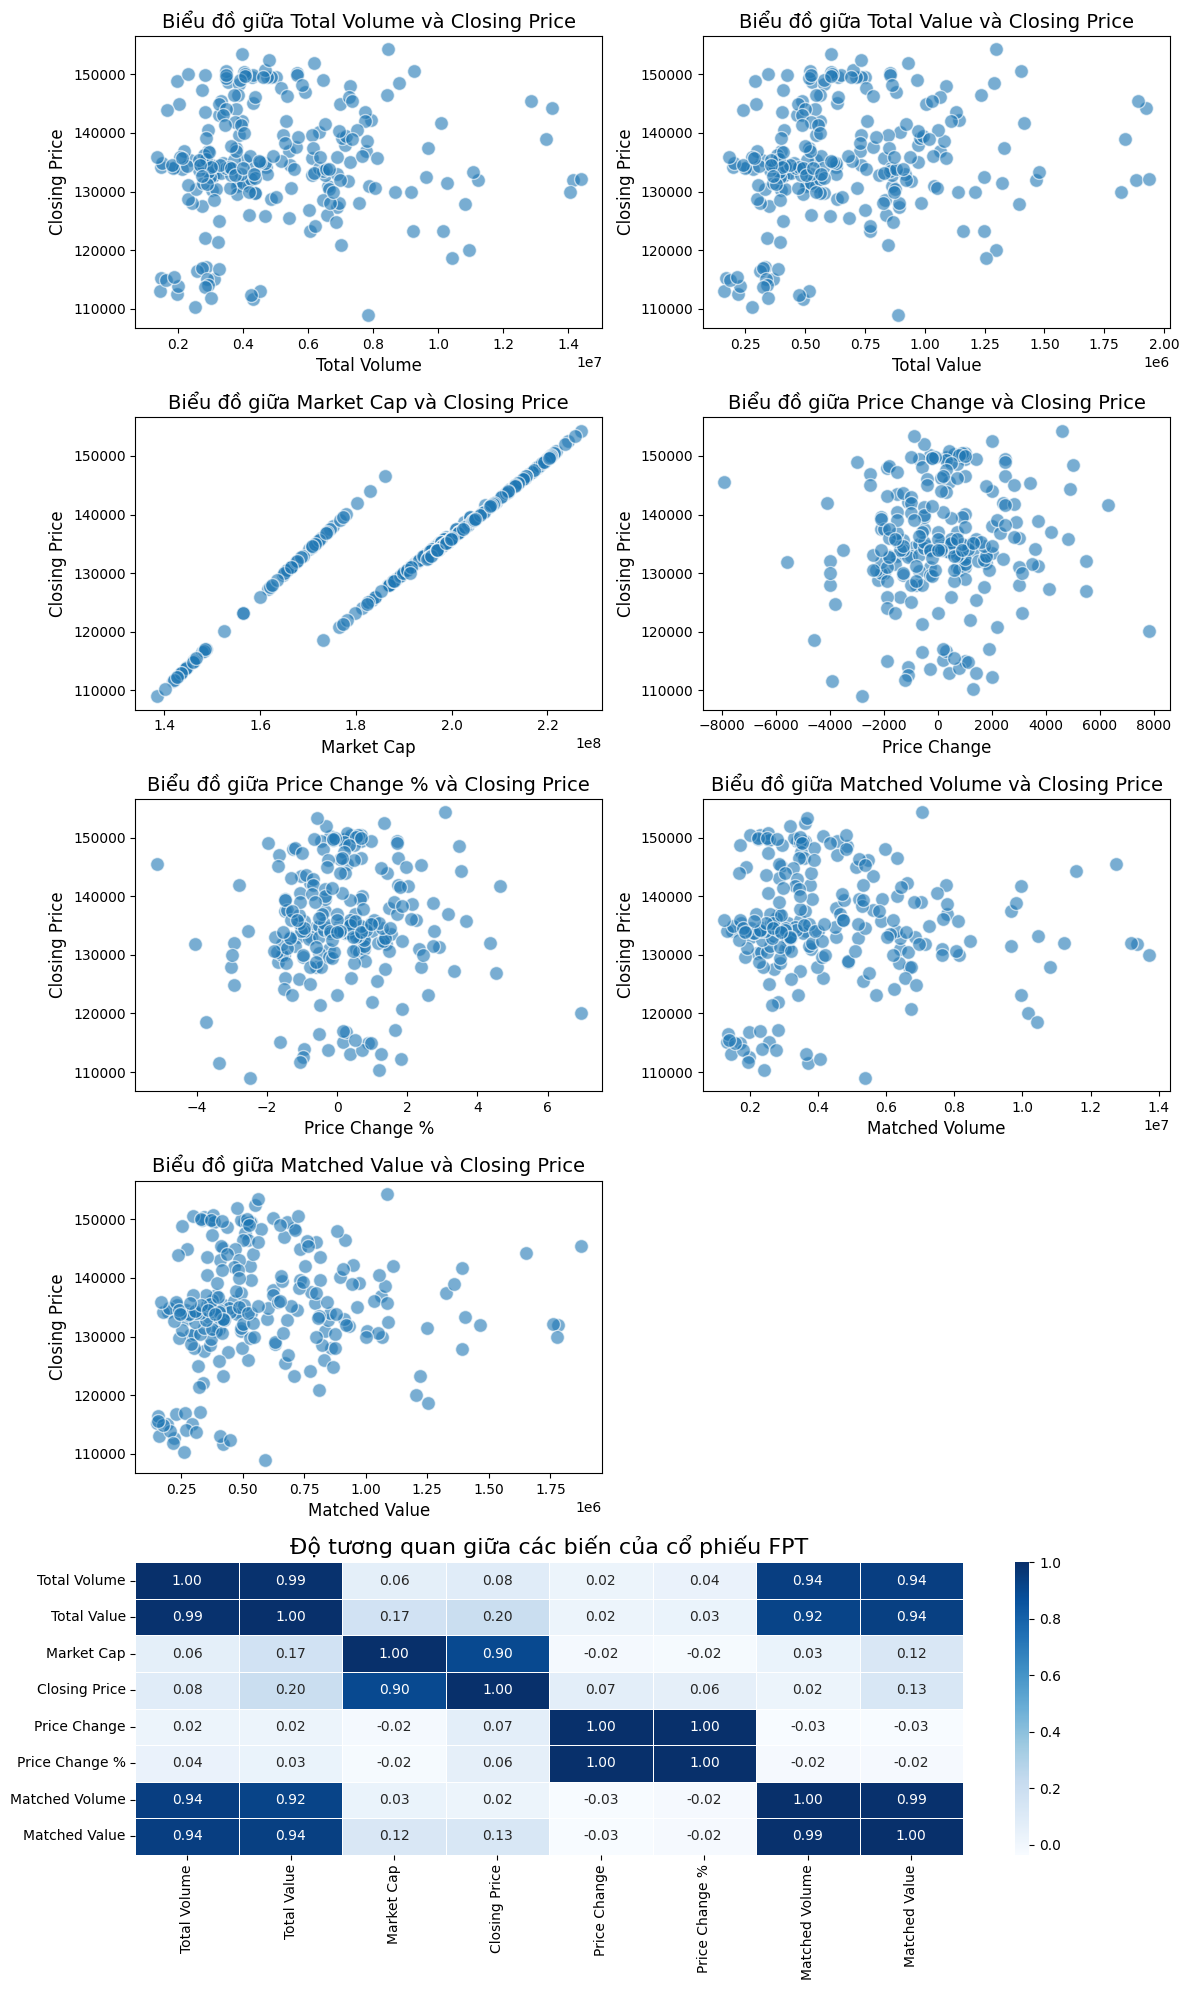

In [8]:
def relationship_plot(key, value):
    print(f"Cổ phiếu {key}")
    X = ['Total Volume', 'Total Value', 'Market Cap',
         'Price Change', 'Price Change %', 'Matched Volume', 'Matched Value']
    y = 'Closing Price'
    
    n_scatter = len(X)
    n_scatter_rows = math.ceil(n_scatter / 2)
    total_rows = n_scatter_rows + 1
    
    fig, axes = plt.subplots(total_rows, 2, figsize=(12, 4*total_rows))
    fig.subplots_adjust(hspace=0.4, wspace=0.3)
    
    for i, col in enumerate(X):
        row = i // 2
        col_idx = i % 2
        axes[row, col_idx].scatter(value[col], value[y], alpha=0.6, edgecolors='w', s=100)
        axes[row, col_idx].set_title(f"Biểu đồ giữa {col} và {y}", fontsize=14)
        axes[row, col_idx].set_xlabel(col, fontsize=12)
        axes[row, col_idx].set_ylabel(y, fontsize=12)
    
    if n_scatter % 2 != 0:
        axes[n_scatter_rows - 1, 1].axis('off')
    
    for j in range(2):
        fig.delaxes(axes[-1, j])
    ax_heat = fig.add_subplot(total_rows, 1, total_rows)
    value_corr = value.select_dtypes(include=[float, int]).corr()
    sns.heatmap(value_corr, annot=True, cmap='Blues', fmt='.2f', linewidths=0.5, ax=ax_heat)
    ax_heat.set_title(f"Độ tương quan giữa các biến của cổ phiếu {key}", fontsize=16)
    
    plt.tight_layout()
    plt.show()

for company, data in stocks.items():
    relationship_plot(company, data)


In [9]:
combined_daily_return = pd.DataFrame({
    'CMG': stocks['CMG']['Price Change %'],
    'FPT': stocks['FPT']['Price Change %']
})

combined_closing_price = pd.DataFrame({
    'CMG': stocks['CMG']['Closing Price'],
    'FPT': stocks['FPT']['Closing Price']
})

combined_daily_return = combined_daily_return.dropna()

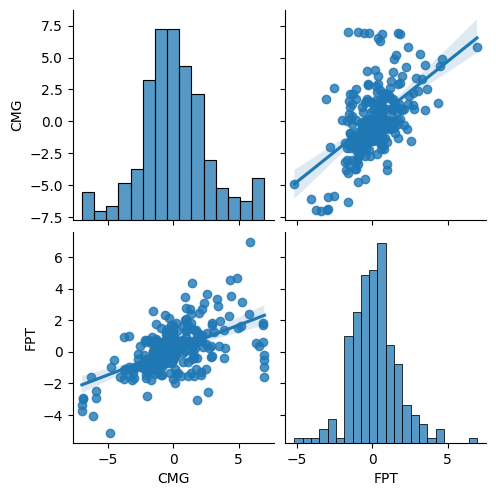

In [10]:
sns.pairplot(combined_daily_return, kind='reg')

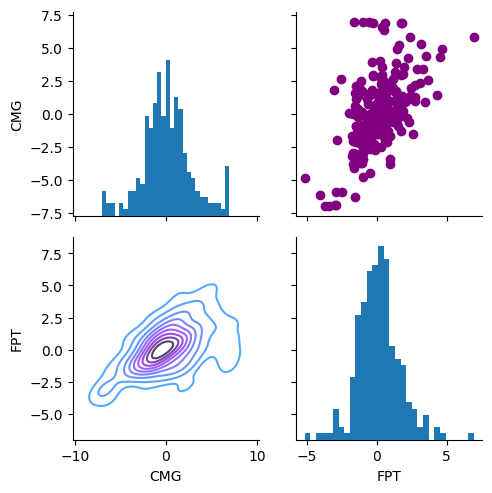

In [11]:
return_fig = sns.PairGrid(combined_daily_return.dropna())
return_fig.map_upper(plt.scatter, color='purple')
return_fig.map_lower(sns.kdeplot, cmap='cool_d')
return_fig.map_diag(plt.hist, bins=30)

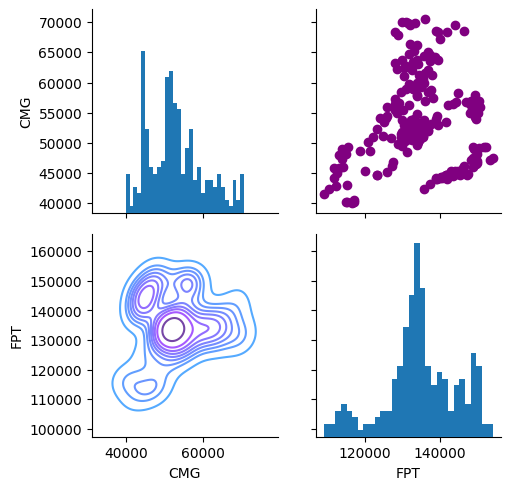

In [12]:
return_fig = sns.PairGrid(combined_closing_price.dropna())
return_fig.map_upper(plt.scatter, color='purple')
return_fig.map_lower(sns.kdeplot, cmap='cool_d')
return_fig.map_diag(plt.hist, bins=30)

Text(0.5, 1.0, 'Correlation of stock closing price')

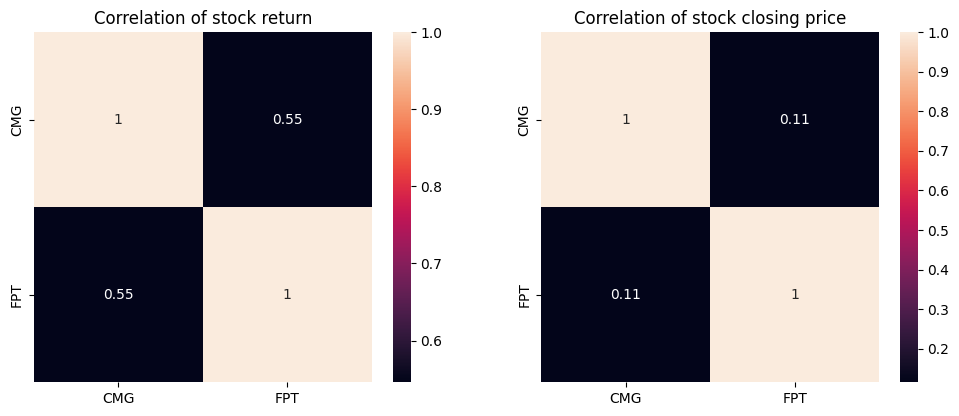

In [13]:
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
sns.heatmap(combined_daily_return.corr(), annot=True)
plt.title('Correlation of stock return')

plt.subplot(2, 2, 2)
sns.heatmap(combined_closing_price.corr(), annot=True)
plt.title('Correlation of stock closing price')

## Feature Selections

In [11]:
def shift_day(df, lags=[1, 2, 3]):
    original_col = df.columns
    df = df.reset_index()
    df = df.sort_values(by='Date', ascending=True)
    for col in original_col[1:]:
        df[f'{col}_ma_3_days'] = df[col].rolling(window=3).mean()
        df[f'{col}_ma_7_days'] = df[col].rolling(window=7).mean()
        for lag in lags:
            df[f'{col}_lag_{lag}'] = df[col].shift(lag)
    df = df.drop(columns=original_col[1:])
    df = df.set_index('Date')
    return df

In [12]:
cmg_lags = shift_day(stocks['CMG'])
fpt_lags = shift_day(stocks['FPT'])

In [28]:
def merge_df(df_main, df_lag):
    result = pd.merge(df_main, df_lag, how='inner', left_index=True, right_index=True)
    result.rename(columns = {'Total Volume_x':'Total Volume'}, inplace=True)
    result.drop(columns='Total Volume_y', inplace=True)
    result.dropna(inplace=True)
    return result
# result.columns = ['CMG_' + col for col in result.columns[:7]] + ['FPT_' + col for col in result.columns[7:]]

In [29]:
merge_cmg = merge_df(stocks['CMG'], cmg_lags)
merge_fpt = merge_df(stocks['FPT'], fpt_lags)

### XGBoost

In [53]:
def xgboost_model_regression(df, test_size=0.3):
    # feature_cols = ['Total Volume', 'Total Value', 'Market Cap',
    #     'Price Change', 'Matched Volume', 'Matched Value', 'Price Change %'
    # ]
    # target_col='Closing Price'
    X = df.drop(columns='Closing Price')
    y = df["Closing Price"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, shuffle=False 
    )
    # fit model
    xgb = XGBRegressor()
    xgb.fit(X_train, y_train)
    y_pred = xgb.predict(X_test)
    print(f"MAE: {mean_absolute_error(y_test, y_pred):.3f}")
    print(f"MSE: {mean_squared_error(y_test, y_pred):.3f}") 
    print(f"RMSE: {math.sqrt(mean_squared_error(y_test, y_pred)):.3f}")
    print(f"R2: {r2_score(y_test, y_pred):.3f}")

    # Lấy importance và chọn threshold
    importances = xgb.feature_importances_
    feature_names = X_train.columns
    feature_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)
    # chọn những feature có importance >= median
    threshold = np.median(importances)

    plt.figure(figsize=(12,8))
    sns.barplot(x=feature_importances.values, y=feature_importances.index)
    plt.title(f"Feature Importances", fontsize=13, fontweight='bold')
    plt.xlabel("Importance", fontsize=11)
    plt.ylabel("Features", fontsize=11)
    plt.grid(True, axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # Dùng SelectFromModel để tự động lọc
    sfm_xgb = SelectFromModel(xgb, threshold=threshold, prefit=True)
    selected_mask = sfm_xgb.get_support() 
    selected_features_xgb = X_train.columns[selected_mask].tolist()

    print("XGBoost selected features:", selected_features_xgb)

In [51]:
def xgboost_model_classifier(df, test_size=0.3):
    # create label 
    df['Target'] = (df['Closing Price'].shift(-1) > df['Closing Price']).astype(int)
    df = df.dropna().reset_index(drop=True)    
    
    X = df.drop(columns=['Closing Price', 'Target'])
    y = df["Target"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, shuffle=False 
    )
    # fit model
    xgb = XGBClassifier()
    xgb.fit(X_train, y_train)
    y_pred = xgb.predict(X_test)
    print("Chỉ tiêu đánh giá:")
    print(f"Accuracy  : {accuracy_score(y_test, y_pred):.3f}")
    print(f"Precision : {precision_score(y_test, y_pred):.3f}")
    print(f"Recall    : {recall_score(y_test, y_pred):.3f}")
    print(f"F1 Score  : {f1_score(y_test, y_pred):.3f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()
    # Lấy importance và chọn threshold
    importances = xgb.feature_importances_
    feature_names = X_train.columns
    feature_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)
    # chọn những feature có importance >= median
    threshold = np.median(importances)

    plt.figure(figsize=(12,8))
    sns.barplot(x=feature_importances.values, y=feature_importances.index)
    plt.title(f"Feature Importances", fontsize=13, fontweight='bold')
    plt.xlabel("Importance", fontsize=11)
    plt.ylabel("Features", fontsize=11)
    plt.grid(True, axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # Dùng SelectFromModel để tự động lọc
    sfm_xgb = SelectFromModel(xgb, threshold=threshold, prefit=True)
    selected_mask = sfm_xgb.get_support() 
    selected_features_xgb = X_train.columns[selected_mask].tolist()

    print("XGBoost selected features:", selected_features_xgb)

MAE: 2409.443
MSE: 11197428.686
RMSE: 3346.256
R2: 0.564


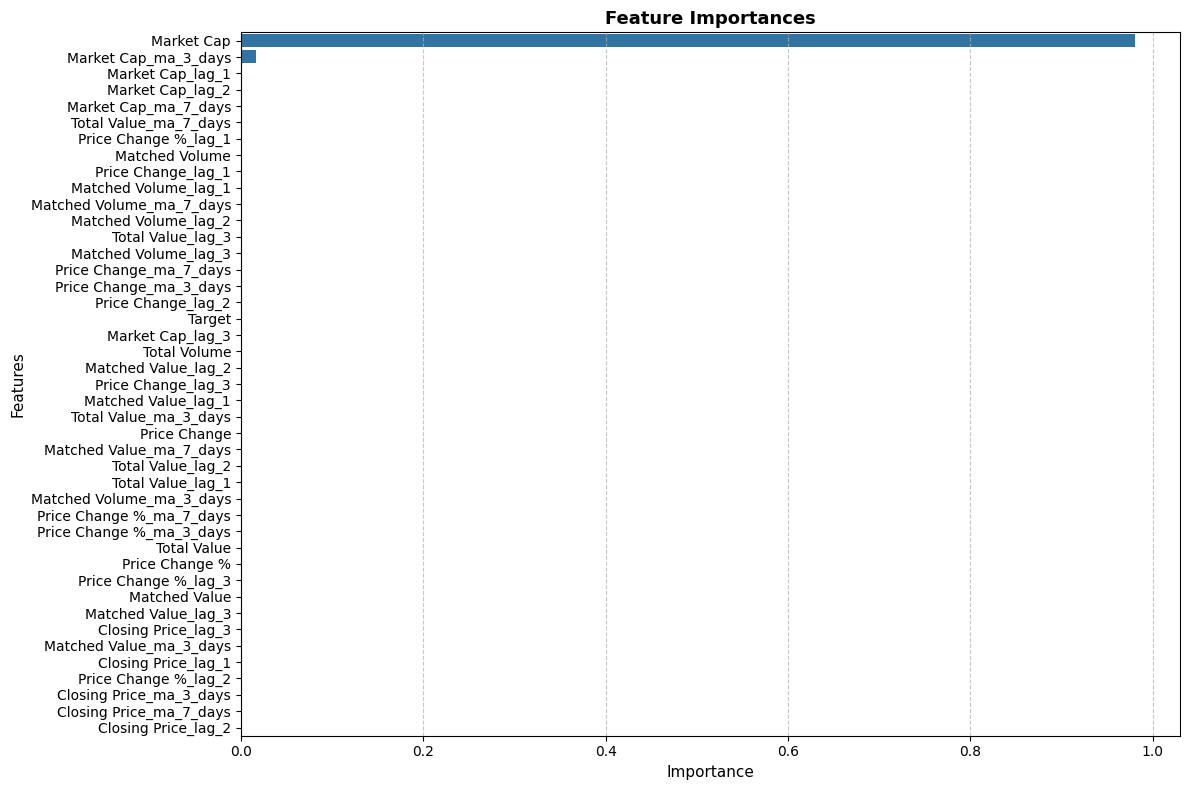

XGBoost selected features: ['Total Volume', 'Market Cap', 'Matched Volume', 'Total Value_ma_7_days', 'Total Value_lag_3', 'Market Cap_ma_3_days', 'Market Cap_ma_7_days', 'Market Cap_lag_1', 'Market Cap_lag_2', 'Market Cap_lag_3', 'Price Change_ma_3_days', 'Price Change_ma_7_days', 'Price Change_lag_1', 'Price Change_lag_2', 'Price Change_lag_3', 'Price Change %_lag_1', 'Matched Volume_ma_7_days', 'Matched Volume_lag_1', 'Matched Volume_lag_2', 'Matched Volume_lag_3', 'Matched Value_lag_2', 'Target']


In [54]:
xgboost_model_regression(merge_cmg)

MAE: 5037.960
MSE: 32528413.728
RMSE: 5703.369
R2: -0.692


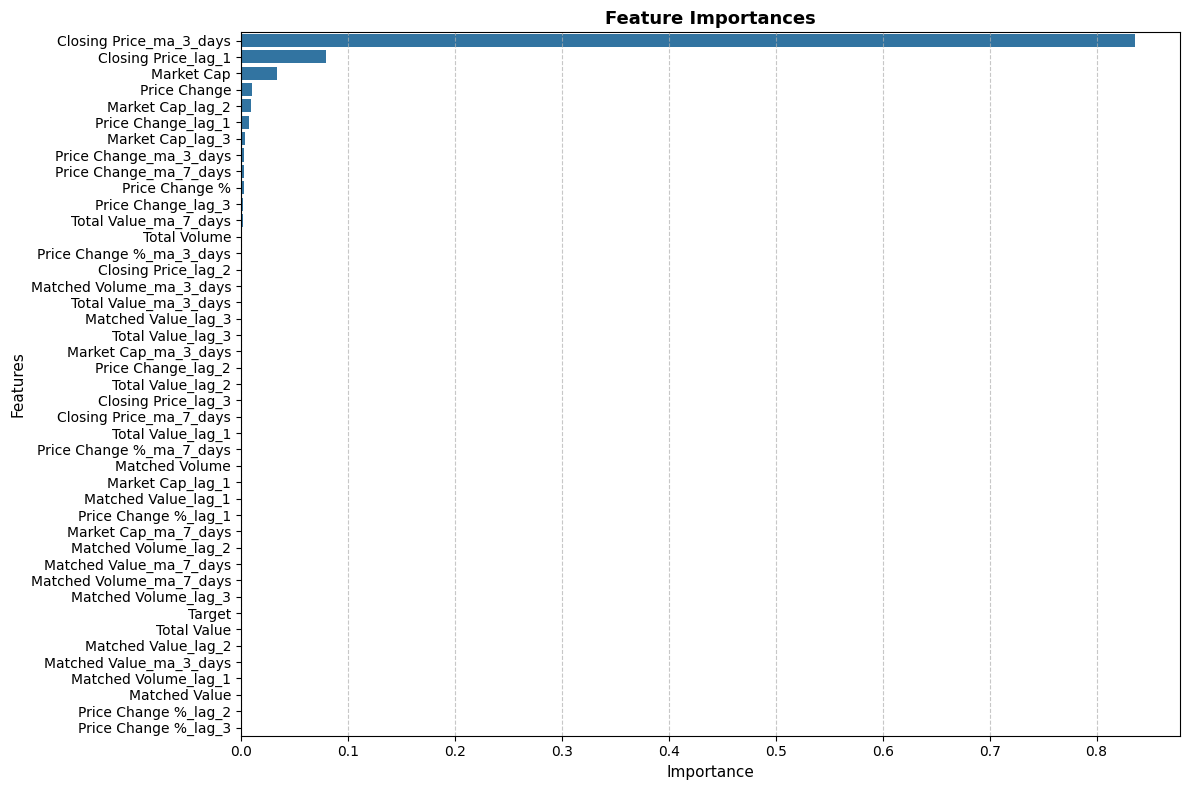

XGBoost selected features: ['Total Volume', 'Market Cap', 'Price Change', 'Price Change %', 'Total Value_ma_3_days', 'Total Value_ma_7_days', 'Total Value_lag_2', 'Total Value_lag_3', 'Market Cap_ma_3_days', 'Market Cap_lag_2', 'Market Cap_lag_3', 'Closing Price_ma_3_days', 'Closing Price_lag_1', 'Closing Price_lag_2', 'Price Change_ma_3_days', 'Price Change_ma_7_days', 'Price Change_lag_1', 'Price Change_lag_2', 'Price Change_lag_3', 'Price Change %_ma_3_days', 'Matched Volume_ma_3_days', 'Matched Value_lag_3']


In [55]:
xgboost_model_regression(merge_fpt)

Chỉ tiêu đánh giá:
Accuracy  : 0.554
Precision : 0.469
Recall    : 0.767
F1 Score  : 0.582

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.41      0.52        44
           1       0.47      0.77      0.58        30

    accuracy                           0.55        74
   macro avg       0.59      0.59      0.55        74
weighted avg       0.62      0.55      0.55        74



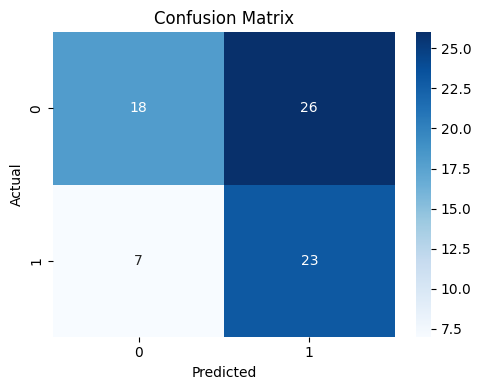

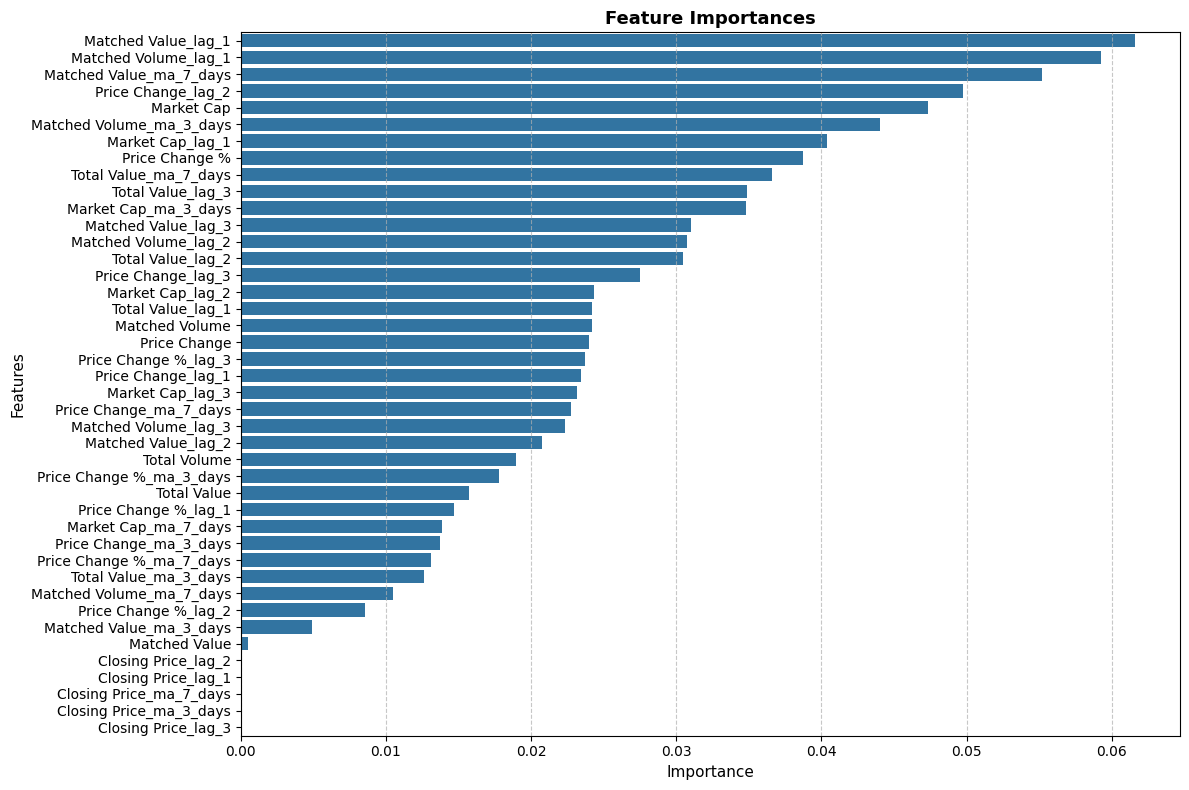

XGBoost selected features: ['Market Cap', 'Price Change', 'Price Change %', 'Matched Volume', 'Total Value_ma_7_days', 'Total Value_lag_1', 'Total Value_lag_2', 'Total Value_lag_3', 'Market Cap_ma_3_days', 'Market Cap_lag_1', 'Market Cap_lag_2', 'Price Change_lag_1', 'Price Change_lag_2', 'Price Change_lag_3', 'Price Change %_lag_3', 'Matched Volume_ma_3_days', 'Matched Volume_lag_1', 'Matched Volume_lag_2', 'Matched Value_ma_7_days', 'Matched Value_lag_1', 'Matched Value_lag_3']


In [56]:
xgboost_model_classifier(merge_cmg)

Chỉ tiêu đánh giá:
Accuracy  : 0.437
Precision : 0.381
Recall    : 0.229
F1 Score  : 0.286

Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.64      0.53        36
           1       0.38      0.23      0.29        35

    accuracy                           0.44        71
   macro avg       0.42      0.43      0.41        71
weighted avg       0.42      0.44      0.41        71



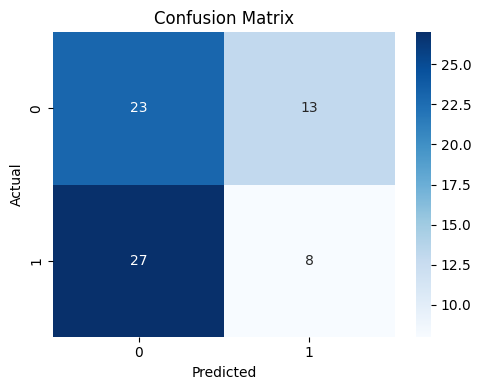

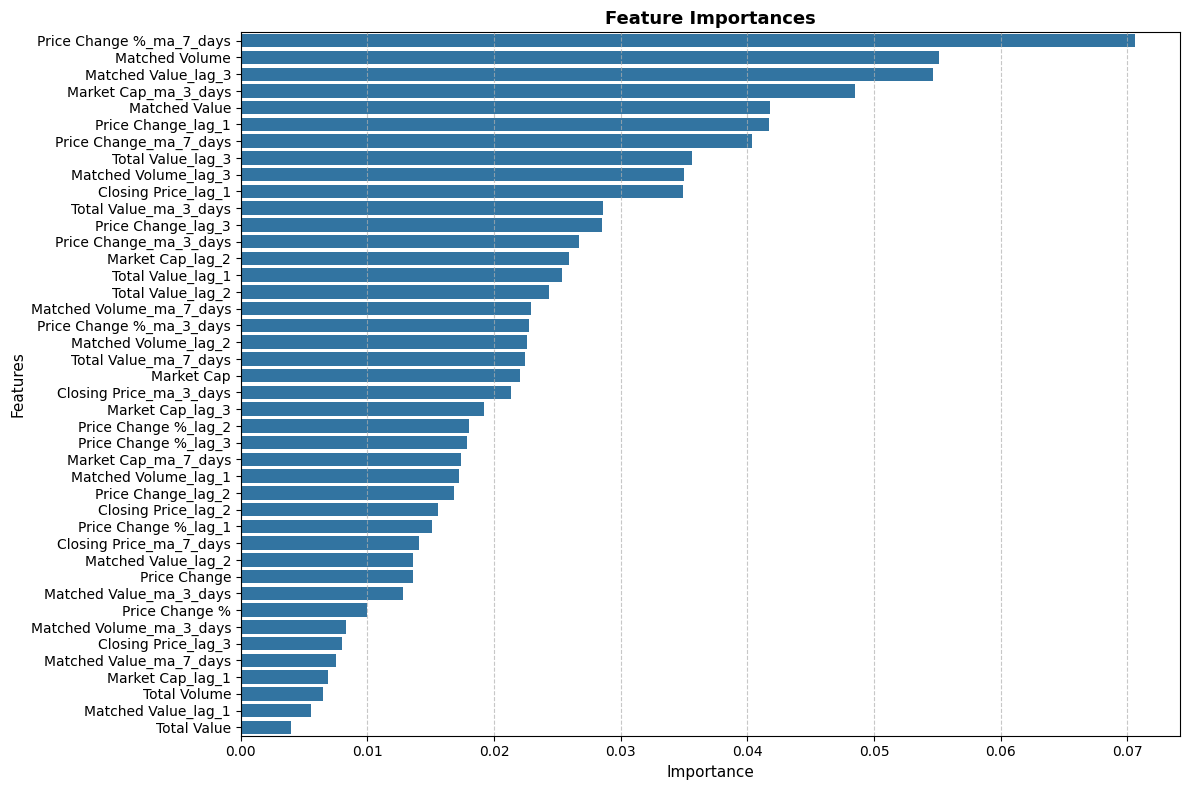

XGBoost selected features: ['Market Cap', 'Matched Volume', 'Matched Value', 'Total Value_ma_3_days', 'Total Value_ma_7_days', 'Total Value_lag_1', 'Total Value_lag_2', 'Total Value_lag_3', 'Market Cap_ma_3_days', 'Market Cap_lag_2', 'Closing Price_lag_1', 'Price Change_ma_3_days', 'Price Change_ma_7_days', 'Price Change_lag_1', 'Price Change_lag_3', 'Price Change %_ma_3_days', 'Price Change %_ma_7_days', 'Matched Volume_ma_7_days', 'Matched Volume_lag_2', 'Matched Volume_lag_3', 'Matched Value_lag_3']


In [57]:
xgboost_model_classifier(merge_fpt)

### LightGBM

In [58]:
def LightGBM_model_regression(df, test_size=0.3):

    X = df.drop(columns='Closing Price')
    y = df["Closing Price"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, shuffle=False 
    )
    # fit model
    lgbm = lgb.LGBMRegressor()
    lgbm.fit(X_train, y_train)
    y_pred = lgbm.predict(X_test)
    print(f"MAE: {mean_absolute_error(y_test, y_pred):.3f}")
    print(f"MSE: {mean_squared_error(y_test, y_pred):.3f}") 
    print(f"RMSE: {math.sqrt(mean_squared_error(y_test, y_pred)):.3f}")
    print(f"R2: {r2_score(y_test, y_pred):.3f}")

    # Lấy importance và chọn threshold
    importances = lgbm.feature_importances_
    feature_names = X_train.columns
    feature_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)
    # chọn những feature có importance >= median
    threshold = np.median(importances)

    plt.figure(figsize=(12,8))
    sns.barplot(x=feature_importances.values, y=feature_importances.index)
    plt.title(f"Feature Importances", fontsize=13, fontweight='bold')
    plt.xlabel("Importance", fontsize=11)
    plt.ylabel("Features", fontsize=11)
    plt.grid(True, axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    # Dùng SelectFromModel để tự động lọc
    sfm_lgbm = SelectFromModel(lgbm, threshold=threshold, prefit=True)
    selected_mask = sfm_lgbm.get_support() 
    selected_features_lgbm = X_train.columns[selected_mask].tolist()

    print("lgbmoost selected features:", selected_features_lgbm)

In [59]:
def LightGBM_model_classifier(df, test_size=0.3):
    # create label 
    df['Target'] = (df['Closing Price'].shift(-1) > df['Closing Price']).astype(int)
    df = df.dropna().reset_index(drop=True)    
    
    X = df.drop(columns=['Closing Price', 'Target'])
    y = df["Target"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, shuffle=False 
    )
    # fit model
    lgbm = lgb.LGBMClassifier()
    lgbm.fit(X_train, y_train)
    y_pred = lgbm.predict(X_test)
    print("Chỉ tiêu đánh giá:")
    print(f"Accuracy  : {accuracy_score(y_test, y_pred):.3f}")
    print(f"Precision : {precision_score(y_test, y_pred):.3f}")
    print(f"Recall    : {recall_score(y_test, y_pred):.3f}")
    print(f"F1 Score  : {f1_score(y_test, y_pred):.3f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    # Lấy importance và chọn threshold
    importances = lgbm.feature_importances_
    feature_names = X_train.columns
    feature_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)
    # chọn những feature có importance >= median
    threshold = np.median(importances)

    plt.figure(figsize=(12,8))
    sns.barplot(x=feature_importances.values, y=feature_importances.index)
    plt.title(f"Feature Importances", fontsize=13, fontweight='bold')
    plt.xlabel("Importance", fontsize=11)
    plt.ylabel("Features", fontsize=11)
    plt.grid(True, axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    # Dùng SelectFromModel để tự động lọc
    sfm_lgbm = SelectFromModel(lgbm, threshold=threshold, prefit=True)
    selected_mask = sfm_lgbm.get_support() 
    selected_features_lgbm = X_train.columns[selected_mask].tolist()

    print("lgbmoost selected features:", selected_features_lgbm)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2294
[LightGBM] [Info] Number of data points in the train set: 170, number of used features: 42
[LightGBM] [Info] Start training from score 54294.117647
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

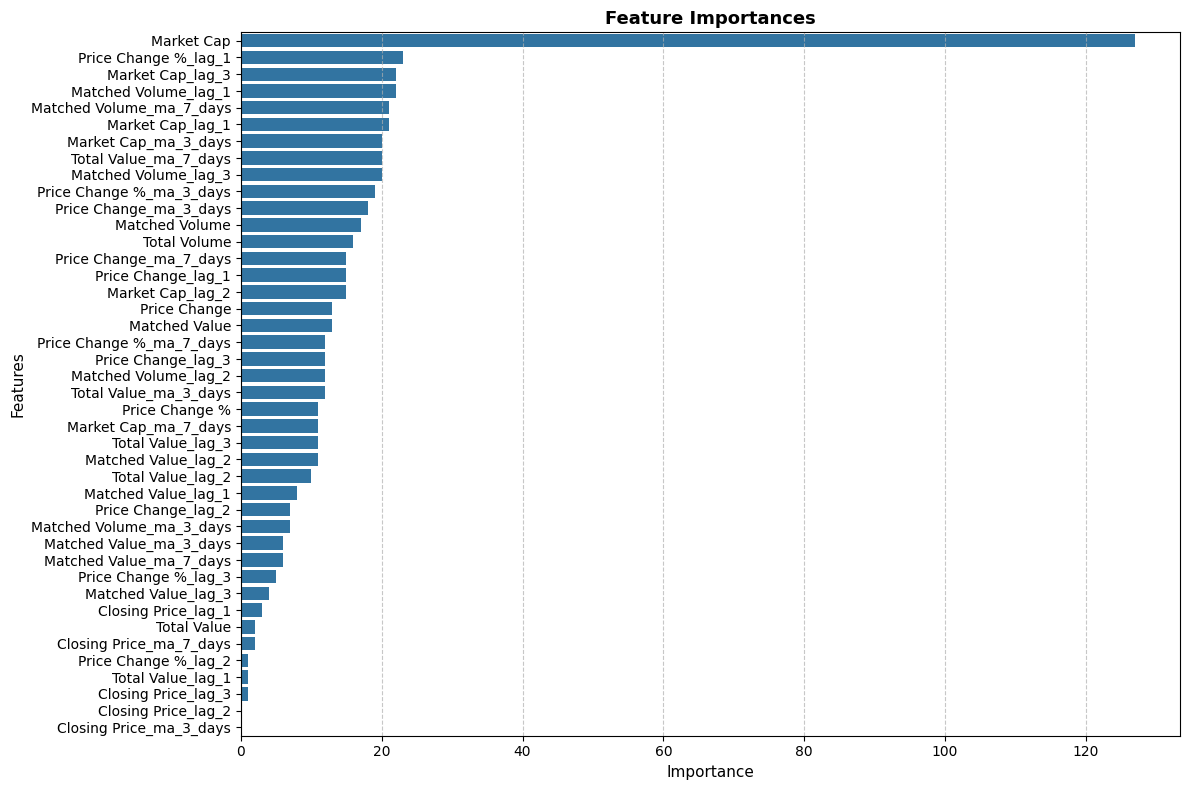

lgbmoost selected features: ['Total Volume', 'Market Cap', 'Price Change', 'Matched Volume', 'Matched Value', 'Total Value_ma_3_days', 'Total Value_ma_7_days', 'Market Cap_ma_3_days', 'Market Cap_lag_1', 'Market Cap_lag_2', 'Market Cap_lag_3', 'Price Change_ma_3_days', 'Price Change_ma_7_days', 'Price Change_lag_1', 'Price Change_lag_3', 'Price Change %_ma_3_days', 'Price Change %_ma_7_days', 'Price Change %_lag_1', 'Matched Volume_ma_7_days', 'Matched Volume_lag_1', 'Matched Volume_lag_2', 'Matched Volume_lag_3']


In [ ]:
LightGBM_model_regression(merge_cmg)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.078343 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2182
[LightGBM] [Info] Number of data points in the train set: 163, number of used features: 42
[LightGBM] [Info] Start training from score 130922.085890
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

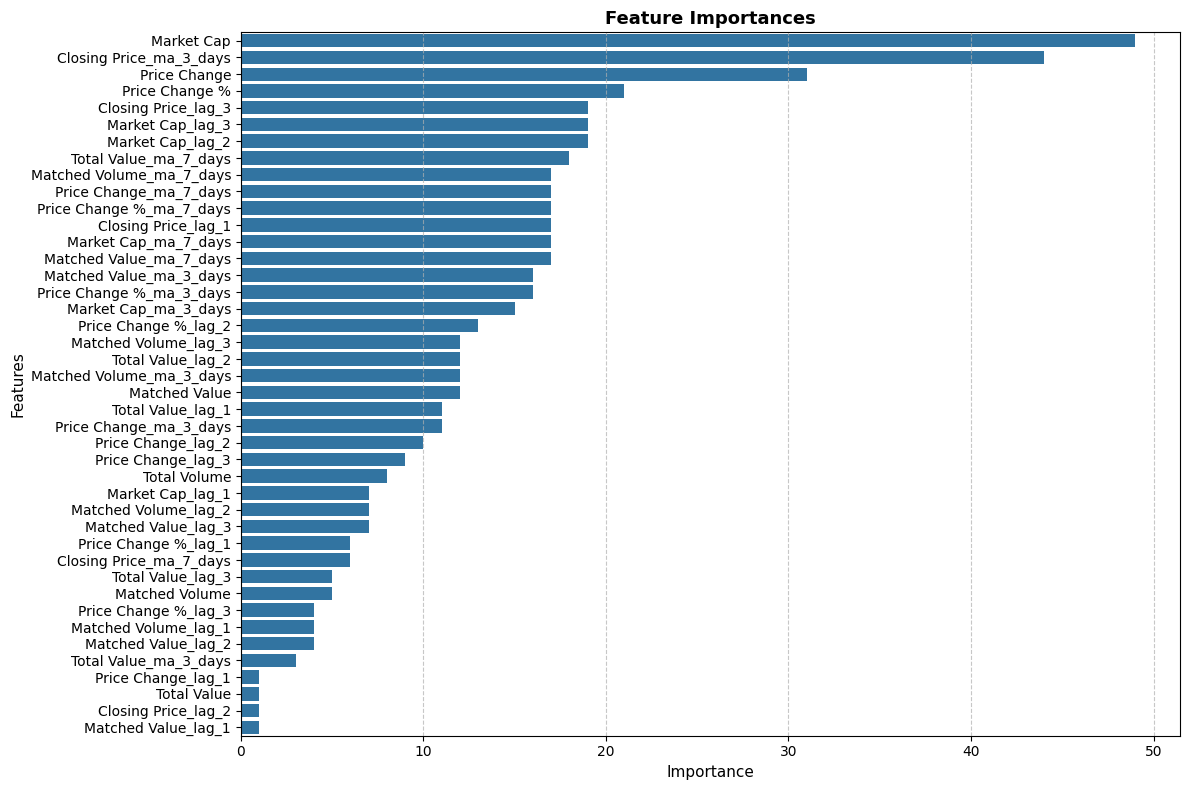

lgbmoost selected features: ['Market Cap', 'Price Change', 'Price Change %', 'Matched Value', 'Total Value_ma_7_days', 'Total Value_lag_2', 'Market Cap_ma_3_days', 'Market Cap_ma_7_days', 'Market Cap_lag_2', 'Market Cap_lag_3', 'Closing Price_ma_3_days', 'Closing Price_lag_1', 'Closing Price_lag_3', 'Price Change_ma_7_days', 'Price Change %_ma_3_days', 'Price Change %_ma_7_days', 'Price Change %_lag_2', 'Matched Volume_ma_3_days', 'Matched Volume_ma_7_days', 'Matched Volume_lag_3', 'Matched Value_ma_3_days', 'Matched Value_ma_7_days']


In [ ]:
LightGBM_model_regression(merge_fpt)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 82, number of negative: 88
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2294
[LightGBM] [Info] Number of data points in the train set: 170, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.482353 -> initscore=-0.070618
[LightGBM] [Info] Start training from score -0.070618
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

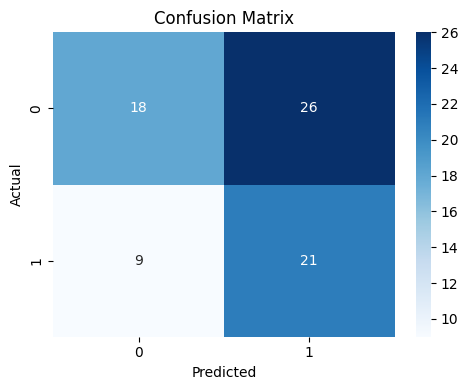

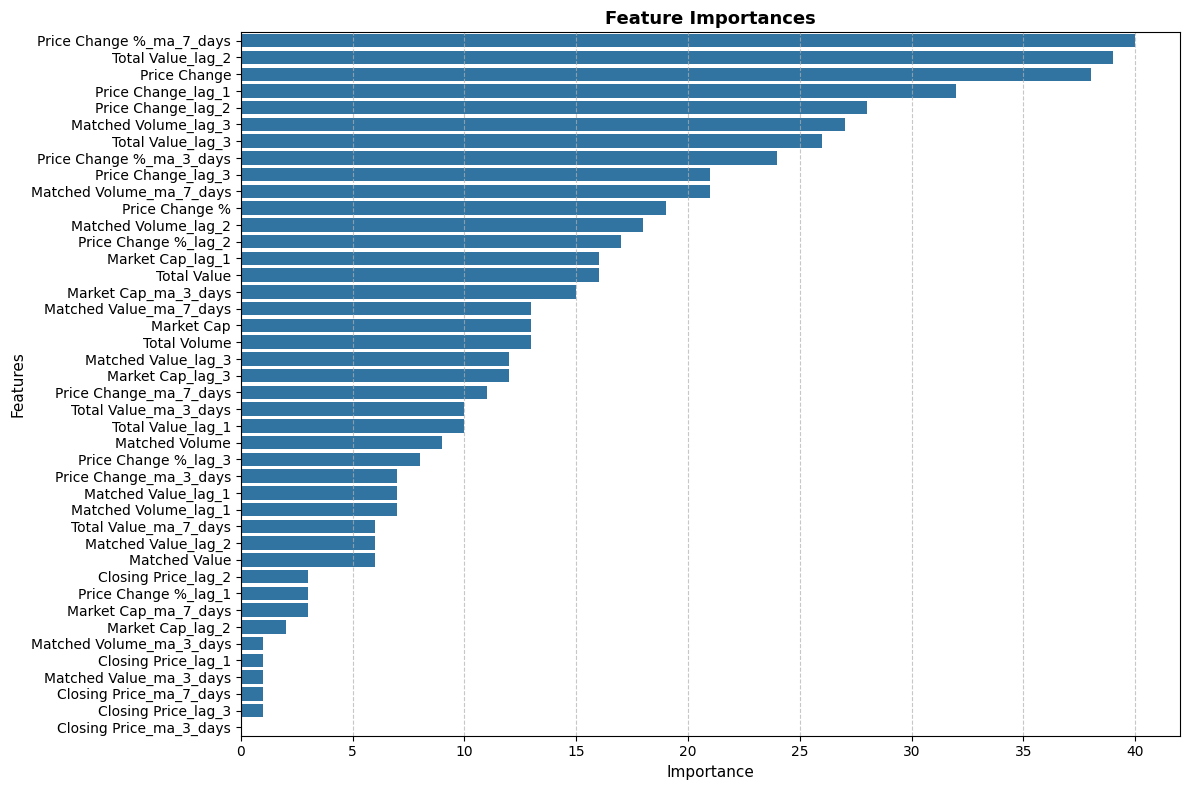

lgbmoost selected features: ['Total Volume', 'Total Value', 'Market Cap', 'Price Change', 'Price Change %', 'Total Value_lag_2', 'Total Value_lag_3', 'Market Cap_ma_3_days', 'Market Cap_lag_1', 'Market Cap_lag_3', 'Price Change_lag_1', 'Price Change_lag_2', 'Price Change_lag_3', 'Price Change %_ma_3_days', 'Price Change %_ma_7_days', 'Price Change %_lag_2', 'Matched Volume_ma_7_days', 'Matched Volume_lag_2', 'Matched Volume_lag_3', 'Matched Value_ma_7_days', 'Matched Value_lag_3']


In [60]:
LightGBM_model_classifier(merge_cmg)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 86, number of negative: 77
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2182
[LightGBM] [Info] Number of data points in the train set: 163, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.527607 -> initscore=0.110542
[LightGBM] [Info] Start training from score 0.110542
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

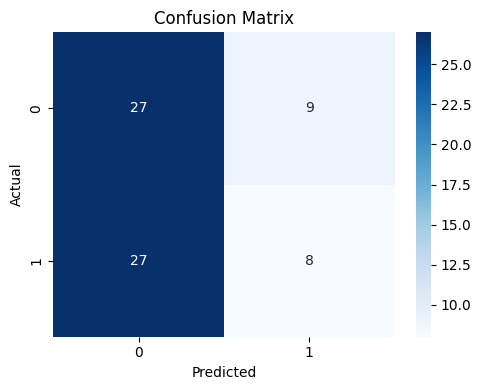

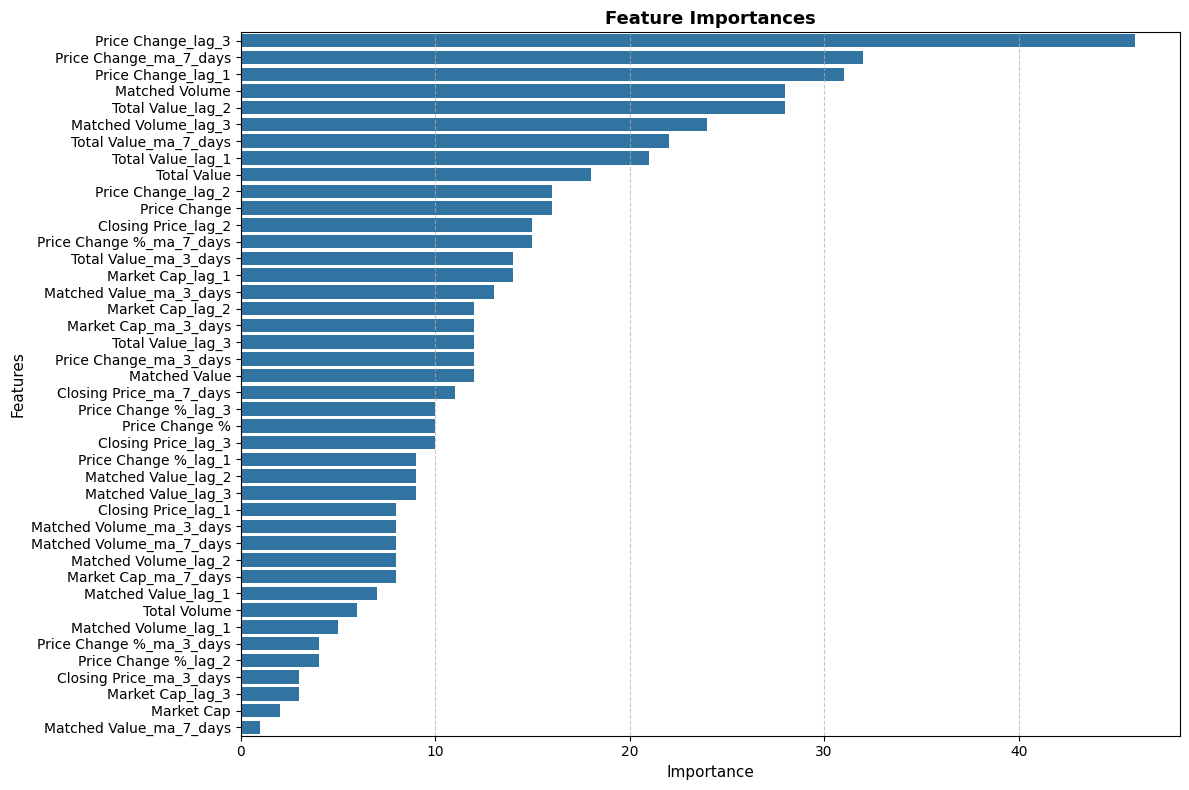

lgbmoost selected features: ['Total Value', 'Price Change', 'Matched Volume', 'Matched Value', 'Total Value_ma_3_days', 'Total Value_ma_7_days', 'Total Value_lag_1', 'Total Value_lag_2', 'Total Value_lag_3', 'Market Cap_ma_3_days', 'Market Cap_lag_1', 'Market Cap_lag_2', 'Closing Price_lag_2', 'Price Change_ma_3_days', 'Price Change_ma_7_days', 'Price Change_lag_1', 'Price Change_lag_2', 'Price Change_lag_3', 'Price Change %_ma_7_days', 'Matched Volume_lag_3', 'Matched Value_ma_3_days']


In [61]:
LightGBM_model_classifier(merge_fpt)

### LSTM

In [22]:
# Tạo chuỗi dữ liệu dùng cho dự báo
def create_sequences(data, time_steps, target_col_index):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps, :])
        y.append(data[i + time_steps, target_col_index])
    return np.array(X), np.array(y)

def train_lstm(df, features_cols, target_col, time_steps=60, test_size=0.3):
    # Chuẩn hóa dữ liệu
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df[features_cols].values)
    target_idx = features_cols.index(target_col)
    
    X, y = create_sequences(scaled_data, time_steps, target_idx)

    # Chia thành bộ train và bộ test
    size = int((1- test_size) * len(X))
    X_train, X_test = X[:size], X[size:]
    y_train, y_test = y[:size], y[size:]

    # Dựng mô hình
    n_features = len(features_cols)
    model = Sequential([
        LSTM(units=64, return_sequences=True, input_shape=(time_steps, n_features)),
        Dropout(0.2),
        LSTM(units=32, return_sequences=True),
        Dropout(0.2),
        LSTM(units=16, return_sequences=False),
        Dropout(0.2),
        Dense(units=10),
        Dense(units=1)
    ])

    model.compile(optimizer='adam', loss='mean_squared_error')

    # Thêm Early Stop để tránh overfitting
    early_stop = EarlyStopping(
        monitor='val_loss', patience=5, restore_best_weights=True, verbose=1
    )

    # Huấn luyện mô hình
    history = model.fit(
        X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test),
        callbacks=[early_stop],
        shuffle=False
    )

    # Đánh giá mô hình
    train_loss = model.evaluate(X_train, y_train, verbose=0)
    test_loss = model.evaluate(X_test, y_test, verbose=0)
    print(f"Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

    # Dự đoán
    y_pred = model.predict(X_test)
    y_pred_full = np.zeros((len(y_pred), n_features))
    y_pred_full[:, target_idx] = y_pred[:, 0]
    y_pred_unscaled = scaler.inverse_transform(y_pred_full)[:, target_idx]

    # tương tự với y_test
    y_true_full = np.zeros((len(y_test), n_features))
    y_true_full[:, target_idx] = y_test
    y_true_unscaled = scaler.inverse_transform(y_true_full)[:, target_idx]

    # Đánh giá dự đoán
    mae = mean_absolute_error(y_true_unscaled, y_pred_unscaled)
    mse = mean_squared_error(y_true_unscaled, y_pred_unscaled)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true_unscaled, y_pred_unscaled)
    
    return {
        'model': model,
        'history': history,
        'metrics': {'MSE': round(mse,2), 'MAE': round(mae,2), 'RMSE': rmse, 'R2': round(r2,2)},
        'y_true': y_true_unscaled,
        'y_pred': y_pred_unscaled
    }

In [23]:
feature_cols = [
    'Total Volume', 'Total Value', 'Market Cap',
    'Closing Price', 'Price Change', 'Matched Volume', 'Matched Value', 'Price Change %'
]
results_lstm = {}
for company, data in stocks.items():
    res = train_lstm(data, feature_cols, target_col='Closing Price', time_steps=30, test_size=0.3)
    results_lstm[company] = res['metrics']

metrics_df = pd.DataFrame(results_lstm).T
print(metrics_df)

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 106ms/step - loss: 0.1725 - val_loss: 0.0237
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0644 - val_loss: 0.0449
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0397 - val_loss: 0.0390
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0343 - val_loss: 0.0370
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0358 - val_loss: 0.0275
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0345 - val_loss: 0.0440
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.
Train Loss: 0.0264, Test Loss: 0.0237
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 234ms/step
Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - loss: 0.1362 - val_loss: 0.0155
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0563 - val_loss: 0.1155
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0223 - val_loss: 0.0594
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0289 - val_lo

## bctc

In [33]:
bctc_dict = {}
bctc_dict['FPT'] = pd.read_csv(r'C:\Users\user\Documents\python\Data_Explorers_2025\Round2\Data - 12ndMar\bctc_FPT.csv')
bctc_dict['CMG'] = pd.read_csv(r'C:\Users\user\Documents\python\Data_Explorers_2025\Round2\Data - 12ndMar\bctc_CMG.csv')
closing_price_dict = {}
closing_price_dict['FPT'] = pd.read_csv(r'C:\Users\user\Documents\python\Data_Explorers_2025\Round2\Data - 12ndMar\Dữ liệu Lịch sử FPT.csv')
closing_price_dict['CMG'] = pd.read_csv(r'C:\Users\user\Documents\python\Data_Explorers_2025\Round2\Data - 12ndMar\Dữ liệu Lịch sử CMG.csv')

In [34]:
for company, data in closing_price_dict.items():
    data['Ngày'] = pd.to_datetime(data['Ngày'], format='%d/%m/%Y')
    data['Lần cuối'] = data['Lần cuối'].replace(',', '', regex=True).astype(float)
    data = data.iloc[::-1]
    data.set_index('Ngày', inplace=True)
    data = data.rename(columns={'Lần cuối': 'Closing Price'})
    closing_price_dict[company] = data

In [36]:
# avg_closing_price_per_quarter_FPT = stocks['FPT'].groupby(stocks['FPT'].index.to_period('Q'))['Closing Price'].mean().reset_index()
avg_closing_price_per_quarter_FPT = closing_price_dict['FPT'].groupby(closing_price_dict['FPT'].index.to_period('Q'))['Closing Price'].mean().reset_index()
avg_closing_price_per_quarter_CMG = closing_price_dict['CMG'].groupby(closing_price_dict['CMG'].index.to_period('Q'))['Closing Price'].mean().reset_index()

In [15]:
avg_closing_price_per_quarter_CMG

Ngày  Closing Price
0  2023Q1       29133.39
1  2023Q2       30338.60
2  2023Q3       34618.30
3  2023Q4       34188.82
4  2024Q1       36594.86
5  2024Q2       51231.02
6  2024Q3       49083.64
7  2024Q4       48644.15
8  2025Q1       45410.00

In [37]:
# avg_closing_price_per_quarter_FPT = avg_closing_price_per_quarter_FPT.rename(columns={'Date': 'Quarter'})
avg_closing_price_per_quarter_FPT = avg_closing_price_per_quarter_FPT.rename(columns={'Ngày': 'Quarter'})
avg_closing_price_per_quarter_CMG = avg_closing_price_per_quarter_CMG.rename(columns={'Ngày': 'Quarter'})
avg_closing_price_per_quarter_FPT

Quarter  Closing Price
0  2023Q1       58772.15
1  2023Q2       59961.08
2  2023Q3       74178.21
3  2023Q4       79565.57
4  2024Q1       89816.14
5  2024Q2      113493.66
6  2024Q3      129865.64
7  2024Q4      139349.39
8  2025Q1      144922.22

In [36]:
# filtered_bctc_FPT = bctc_FPT[(bctc_FPT['Time'] == 'Q1_2024') | (bctc_FPT['Time'] == 'Q2_2024') | (bctc_FPT['Time'] == 'Q3_2024') | (bctc_FPT['Time'] == 'Q4_2024')]

In [38]:
# Handle 'Quarter' column creation for both FPT and CMG
bctc_dict['FPT']['Quarter'] = bctc_dict['FPT']['Time'].apply(lambda x: x.split('_')[1] + x.split('_')[0])
bctc_dict['CMG']['Quarter'] = bctc_dict['CMG']['Indicator'].apply(lambda x: x.split('_')[1] + x.split('_')[0])

In [39]:
# Convert the 'Quarter' column in avg_closing_price_per_quarter_FPT to string to match the type in filtered_bctc_FPT
avg_closing_price_per_quarter_FPT['Quarter'] = avg_closing_price_per_quarter_FPT['Quarter'].astype(str)
avg_closing_price_per_quarter_CMG['Quarter'] = avg_closing_price_per_quarter_CMG['Quarter'].astype(str)

# Perform the merge
merged_df_FPT = pd.merge(bctc_dict['FPT'], avg_closing_price_per_quarter_FPT, on='Quarter', how='left')
merged_df_CMG = pd.merge(bctc_dict['CMG'], avg_closing_price_per_quarter_FPT, on='Quarter', how='left')

In [40]:
merged_df_FPT.drop(columns=['Time', 'Quarter'], inplace=True)
merged_df_CMG.drop(columns=['Indicator', 'Quarter'], inplace=True)

In [41]:
correlation_matrix_FPT = merged_df_FPT.corr()
correlation_matrix_CMG = merged_df_CMG.corr()
# In ma trận tương quan
# print(correlation_matrix)

# # Lấy độ tương quan giữa Closing Price với các biến khác
# closing_price_correlations = correlation_matrix['Closing Price'].sort_values(ascending=False)
# print("Tương quan của Closing Price với các biến khác:")
# print(closing_price_correlations)


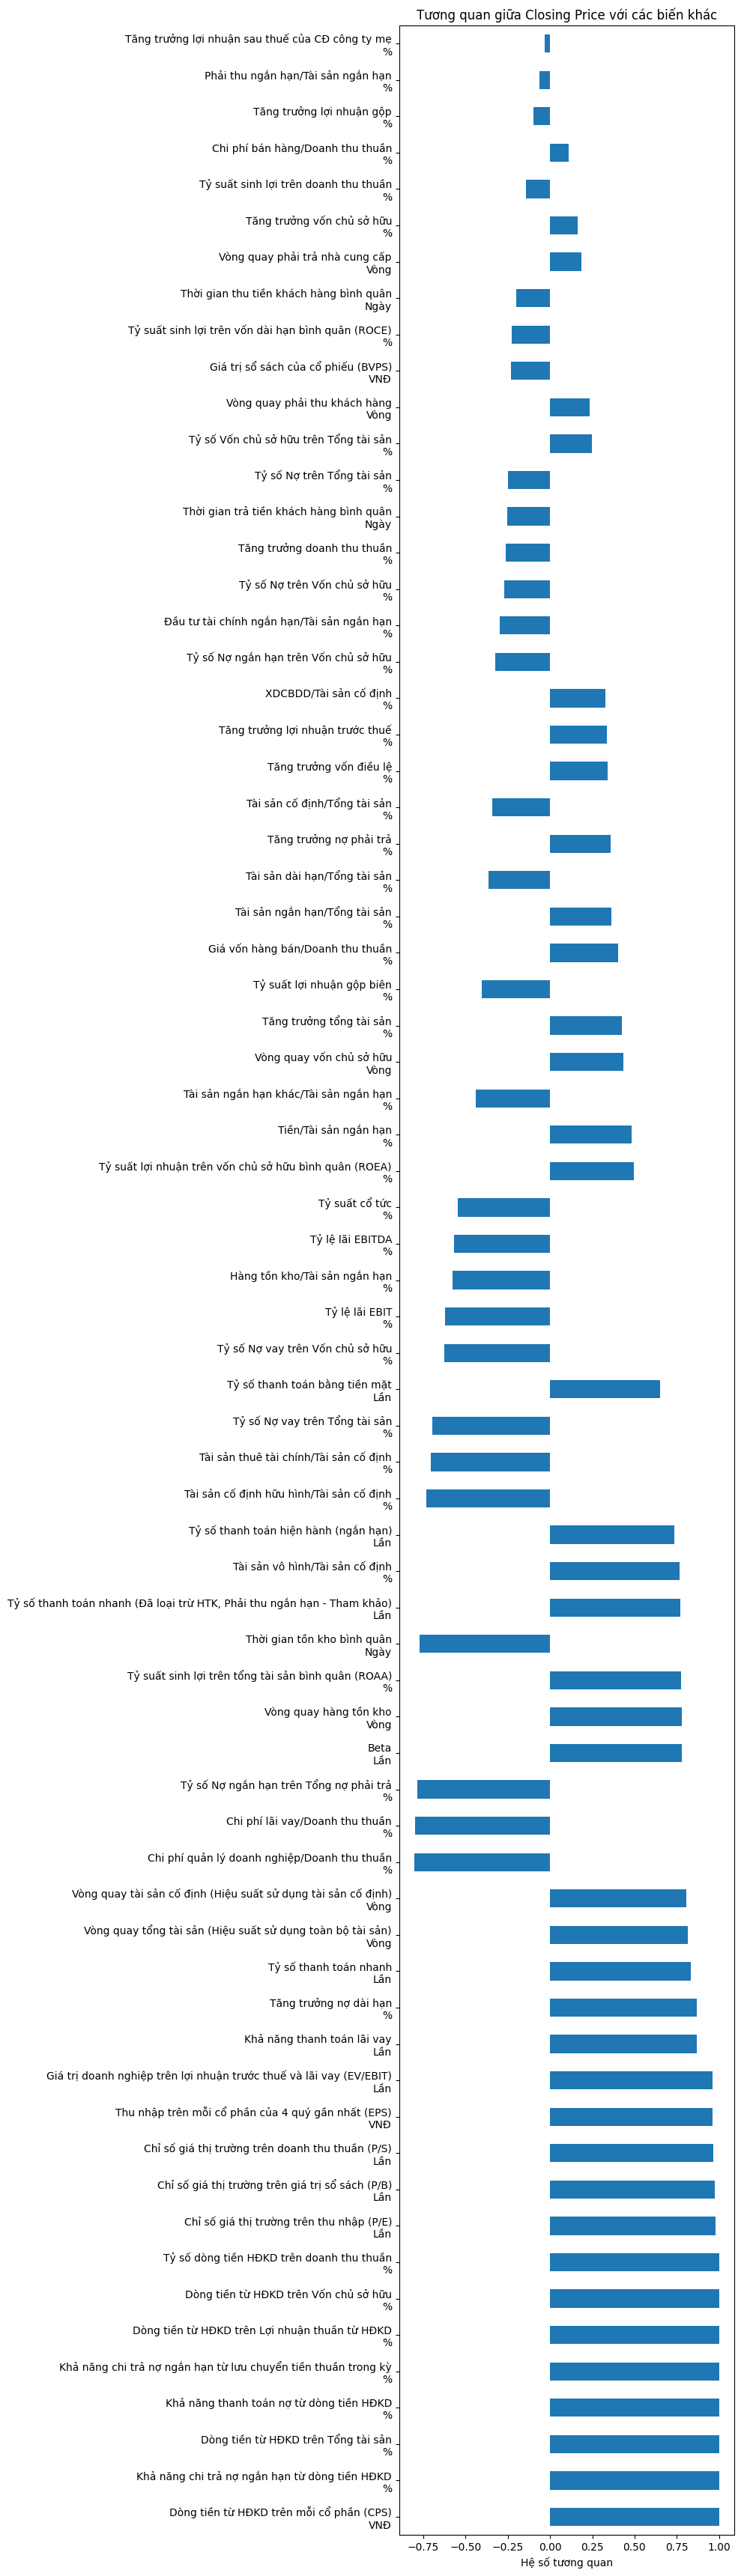

In [ ]:
cp_corr = correlation_matrix_FPT['Closing Price'].drop('Closing Price')
cp_corr_sorted = cp_corr.reindex(cp_corr.abs().sort_values(ascending=False).index)

num_vars = len(cp_corr_sorted)

plt.figure(figsize=(10, num_vars * 0.5)) 

ax = cp_corr_sorted.plot(kind='barh')
plt.title("Tương quan giữa Closing Price với các biến khác")
plt.xlabel("Hệ số tương quan")
plt.tight_layout()
plt.show()

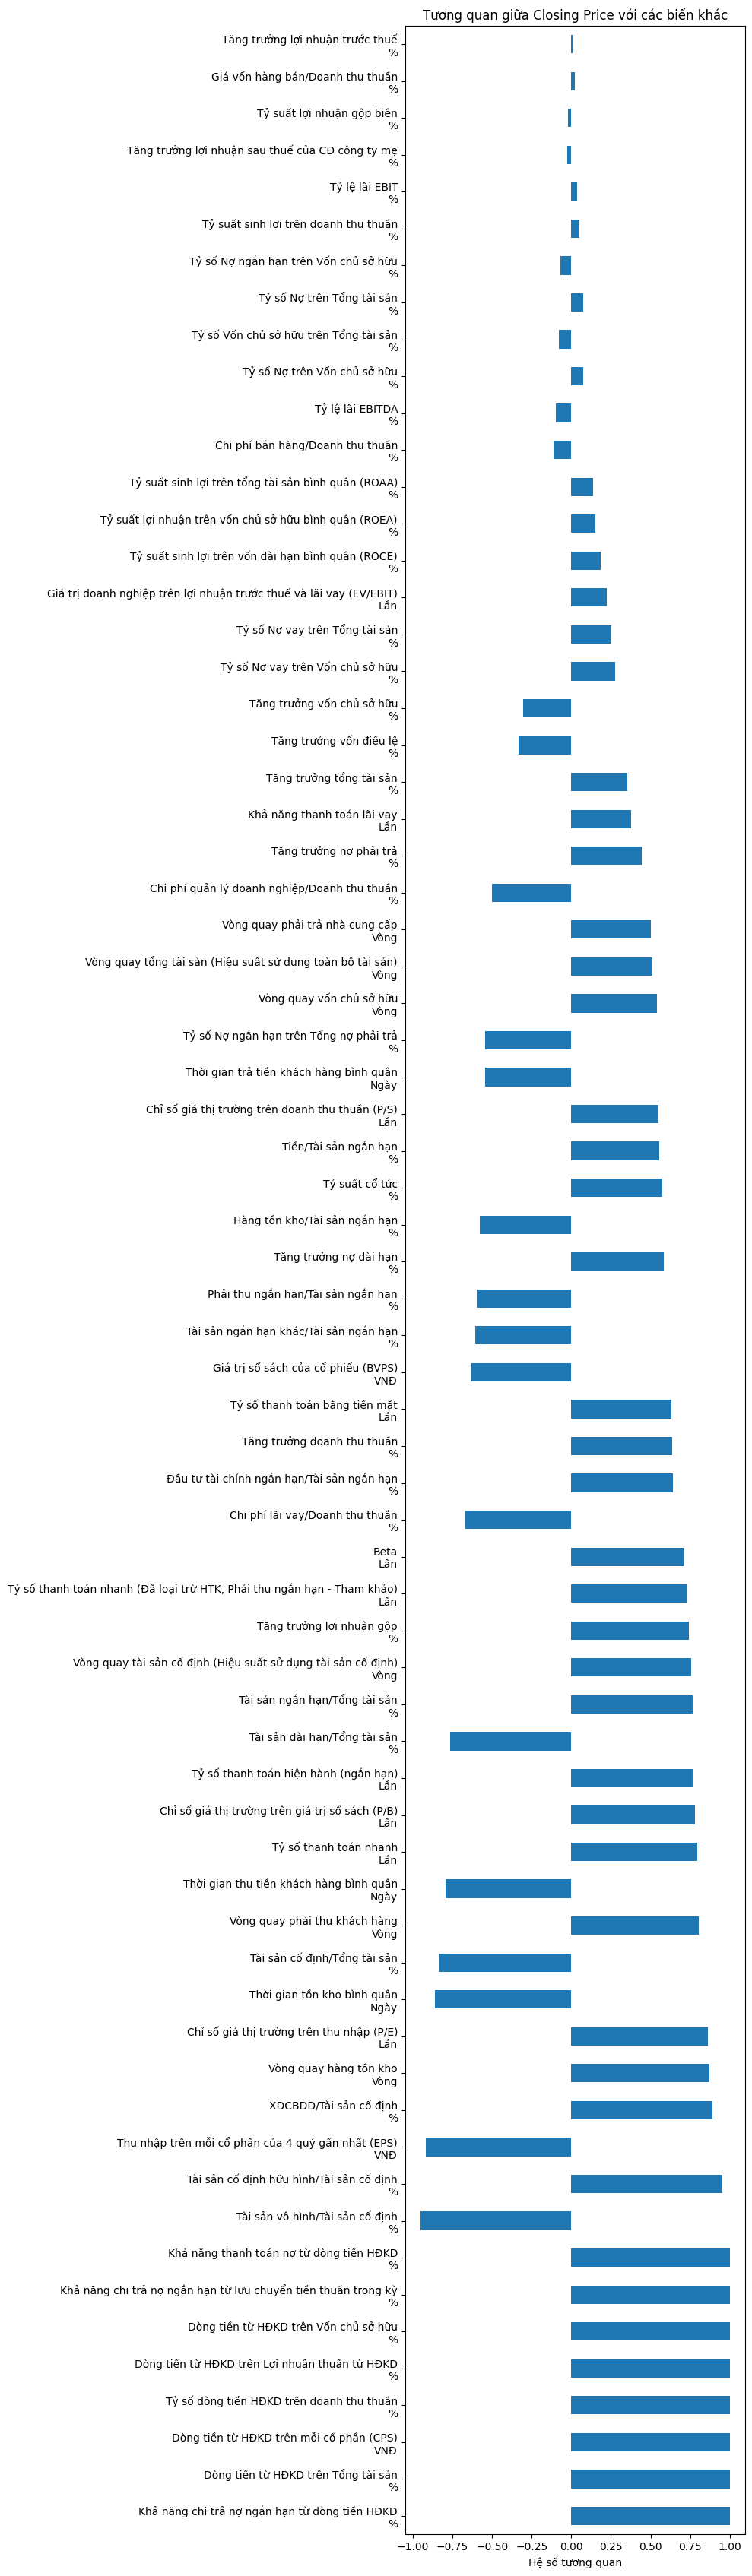

In [42]:
cp_corr = correlation_matrix_CMG['Closing Price'].drop('Closing Price')
cp_corr_sorted = cp_corr.reindex(cp_corr.abs().sort_values(ascending=False).index)

num_vars = len(cp_corr_sorted)

plt.figure(figsize=(10, num_vars * 0.5)) 

ax = cp_corr_sorted.plot(kind='barh')
plt.title("Tương quan giữa Closing Price với các biến khác")
plt.xlabel("Hệ số tương quan")
plt.tight_layout()
plt.show()